In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#basics
import sys,os
sys.path.insert(1, os.path.dirname(os.getcwd()))

#utils
import paths

#main libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option("display.precision", 4)
%matplotlib inline

#model Libraries
from sklearn import utils
from sklearn import preprocessing

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GroupKFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error

In [3]:
#private modules 
#data
from src.data import make_dataset

#utils
from src.utils import memory_usage

#models
from src.models import train_model
from src.models import evaluation
from src.models import metrics
from src.models import metrics_description

In [5]:
%%time
df_training,features,target = make_dataset.get_data(nrows=5000,
                                                    low_memory=True, 
                                                    dataset="training", 
                                                    feather=True)

low memory activated
Memory usage after optimization is: 3.08 MB
Decreased by 49.1%
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 314 entries, id to target_kazutsugi
dtypes: float16(311), int32(1), object(2)
memory usage: 3.1+ MB
None
CPU times: user 1.65 s, sys: 3.52 s, total: 5.17 s
Wall time: 6.75 s


In [6]:
%%time
df_validation,features,target = make_dataset.get_data(nrows=None,
                                                    low_memory=True, 
                                                    dataset="validation", 
                                                    feather=True)

low memory activated
Memory usage after optimization is: 65.86 MB
Decreased by 49.1%
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106895 entries, 0 to 106894
Columns: 314 entries, id to target_kazutsugi
dtypes: float16(311), int32(1), object(2)
memory usage: 65.4+ MB
None
CPU times: user 7.06 s, sys: 3.01 s, total: 10.1 s
Wall time: 10.1 s


In [7]:
memory_usage.memory()

Available memory (%): 21.700000762939453


In [8]:
results, res_cv = list(), dict()

In [9]:
rf_param_grid =  {
    'rf__n_estimators' : [10],
}


#encoding target to multiclass
#(df[target]*4).astype(int))
lab_enc = preprocessing.LabelEncoder()
encoded_target_train = lab_enc.fit_transform(df_training[target])


#Group K-fold
CV = GroupKFold(n_splits = 3)
grp = list(CV.split(X = df_training[features], y = df_training[target],  groups = df_training.era.values))


#scorer function
scorer = make_scorer(roc_auc_score, multi_class='ovr', needs_proba=True, average='weighted')

result = evaluation.evaluate_model(df_training[features], encoded_target_train,
                                   RandomForestClassifier(), 'rf',
                                   rf_param_grid, 
                                   scorer, 
                                   n_iter=1, 
                                   cv_folds=grp,
                                   pipeline=None)

results.append(result)
res_cv[result[1]] = evaluation.get_cv_scores(result[0])

==> Starting K-fold cross validation for rf model, 5000 examples
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.4s finished


==> Elapsed seconds: 3.794
Best rf model: RandomForestClassifier(n_estimators=10)
Best rf score (val): 0.532


In [10]:
lr_param_grid =  {
    'lr__n_jobs' : [-1],

}

#model = XGBRegressor(max_depth=5, learning_rate=0.01, n_estimators=2000, n_jobs=-1, colsample_bytree=0.1)

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Train the model
reg = LinearRegression()


scorer = make_scorer(mean_squared_error)

result = evaluation.evaluate_model(df_training[features], df_training[target],
                                   LinearRegression(), 'lr',
                                   lr_param_grid, 
                                   scorer, n_iter=1, 
                                   cv_folds=grp, pipeline=None)

results.append(result)
res_cv[result[1]] = evaluation.get_cv_scores(result[0])

==> Starting K-fold cross validation for lr model, 5000 examples
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


==> Elapsed seconds: 1.392
Best lr model: LinearRegression(n_jobs=-1)
Best lr score (val): 0.135


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.2s finished


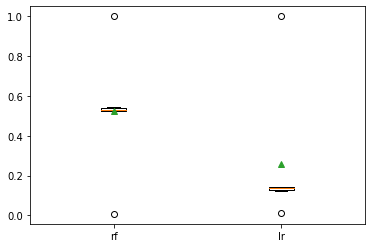

In [11]:
_ = plt.boxplot(res_cv.values(), labels=res_cv.keys(), showmeans=True)

In [12]:
#salvando o pipeline completo
file_path = '../../models/sao_paulo-pipeline.pkl'

model = list(filter(lambda x: x[1] == 'rf', results))[0][0]
model.save(file_path)

In [ ]:
#salvando apenas o modelo
from joblib import dump, load
dump(model.model, '../../models/sao_paulo-baseline.pkl')

In [ ]:
#carregando o modelo
model_loaded = load(file_path)

### 2a Parte: Metricas

Your submission is scored on the correlation between your predictions and the true targets. The higher the correlation the better.



#### Metricas Submissão:

- Validation Correlation {3.6%..4.4%} (4.8% overfit) (The mean of your per-era correlations)
- Validation Sharpe (per era mean/std)
- Corr With Example Preds (example scripts xgboost)
- Feature Exposure (acima de .08 é mto alto, mas 0.07 é dificil)(example scripts caiu de  .22 para .15 com neutralizacao)


### Metricas Leaderboard (live data):
- Correaltion (spearman??)
- MMC
- Corr W/Metamodel

#### Ranking (média correlation dos ultimos 20 rounds)
- Reputation 
- MMC Rep



#### Métricas Modelo (Classificacao - Multi) (pegar ideias do pycaret)
- AUC {0.515..0.520} (+que isso é overffiting)
- Acuracia
- F1


#### Métricas Modelo (Regressão)
- MSE
- Rˆ2


#### Métricas Modelo (Ranking)
- ????




#### Notas

- MSE looks worse than correlation out of sample (tips & tricks)

- Validation correlation: The mean of your per-era correlations.Is this computed using the predictions of the validation data set and the real targets of the validation dataset



- Corr With Example Preds: This is the correlation between your model and the example predictions. Which are the example predictions and agains which dataset are calculated?



 - For calculating feature exposure: Calculate the pearson correlation between feature 1 and your predictions, between feature 2 and your predictions, … …, between feature 310 and your predictions.
 
 
- For optimization I also use smart sharpe ratio and smart sortino ratio (sharpe/sortino ratio with an autocorrelation penalty). These were discussed in another thread of this forum. 


In [13]:
model = list(filter(lambda x: x[1] == 'rf', results))[0][0]
preds = model.model.predict(model.pipeline.transform(df_validation[features]))

Qtde. eras: 22
performance over time


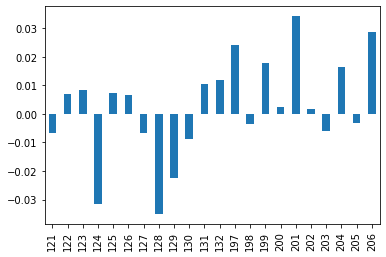

In [14]:
era_scores, era_df, df_metrics = metrics.submission_metrics(df_validation, preds, model.name)

In [15]:
df_metrics

,Valor,Categoria,Range_Aceitavel,Descricao
Metrica,,,,
Model_Name,rf,Submission,NA,Nome do Modelo
Max_Drawdown,-0.03499,Financeira,[..],Perda máxima em uma era
Avg_corr,0.002376,Submission,[..],...
Median_corr,0.004452,Estatistica,[..],...
Variance,0.0002926,Estatistica,[..],...
Std_Dev,0.0171,Estatistica,[..],...
AR(1),0.1281,Estatistica,[..],...
Skewness,-0.3869,Estatistica,[..],...
Exc_Kurtosis,-0.07211,Estatistica,[..],...


##### Metricas regressao (melhorar para o SP)

In [16]:
model = list(filter(lambda x: x[1] == 'lr', results))[0][0]
preds = model.model.predict(model.pipeline.transform(df_validation[features]))

# Evaluate the model
print('Model performance on validation set:')
score = model.model.score(df_validation[features], df_validation[target])  #default deve ser o R2
mse = mean_squared_error(df_validation[target], preds)
print(f'Training R^2: {score}')
print(f'Training MSE: {mse}')

Model performance on validation set:
Training R^2: -0.10671030742008147
Training MSE: 0.1381569653749466


Qtde. eras: 22
performance over time


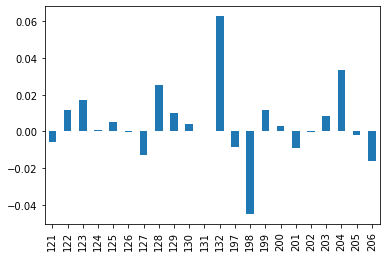

In [17]:
era_scores, era_df, df_metrics = metrics.submission_metrics(df_validation, preds, model.name)

##### Metricas Classificacao (OK)

In [19]:
model = list(filter(lambda x: x[1] == 'rf', results))[0][0]
preds = model.model.predict(model.pipeline.transform(df_validation[features]))
#preds = minmax_scale(preds)

              precision    recall  f1-score   support

           0       0.23      0.28      0.25     21352
           1       0.21      0.26      0.23     21363
           2       0.22      0.23      0.23     21474
           3       0.21      0.17      0.19     21362
           4       0.23      0.15      0.19     21344

    accuracy                           0.22    106895
   macro avg       0.22      0.22      0.22    106895
weighted avg       0.22      0.22      0.22    106895



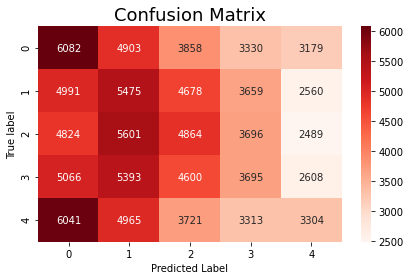

In [20]:
evaluation.plot_confusion_matrix(lab_enc.fit_transform(df_validation[target]), preds)

Rascunho

In [ ]:
MODEL_FILE = Path("example_model.xgb")

if MODEL_FILE.is_file():
    print("Loading pre-trained model...")
    model.load_model(MODEL_FILE)

In [ ]:
%%time
#from joblib import parallel_backend

#with parallel_backend('threading', n_jobs=-1):
    # Train the model
    #model = RandomForestClassifier(n_estimators=10, n_jobs=-1)
    #model.fit(df_training[features], encoded_target_train)
    # Test the model
    #y_pred = clf.predict(X_test)
